In [2]:
import splitfolders

input_path = r"Sugarcane Leaf Disease Dataset"
output_path = r"sugarcane dataset version 2"
splitfolders.ratio(input_path, output=output_path, seed=1337, ratio=(.8, .1, .1))

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_data_dir=r"sugarcane dataset version 2\train"
val_data_dir=r"sugarcane dataset version 2\test"
test_data_dir=r"sugarcane dataset version 2\test"

img_width,img_height=224,224
batch_size=32

train_datagen=ImageDataGenerator(#rescale=1./255,
                                 rotation_range=45,
                                 width_shift_range=0.3,
                                 height_shift_range=0.3,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

val_datagen=ImageDataGenerator()#rescale=1./255)

test_datagen=ImageDataGenerator()#rescale=1./255)

train_generator=train_datagen.flow_from_directory(train_data_dir,
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

val_generator=val_datagen.flow_from_directory(val_data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode='categorical')

test_generator=test_datagen.flow_from_directory(test_data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode='categorical')

Found 1472 images belonging to 5 classes.
Found 189 images belonging to 5 classes.
Found 189 images belonging to 5 classes.


In [2]:
train_generator.class_indices

{'Healthy': 0, 'Mosaic': 1, 'RedRot': 2, 'Rust': 3, 'Wolly Aphid': 4}

In [5]:
train_class_names = set()
num_train_samples=0
for i in train_generator.filenames:
    train_class_names.add(i.split('\\')[0])
    num_train_samples+=1
print(num_train_samples)
train_class_names

val_class_names = set()
num_val_samples=0
for i in val_generator.filenames:
    val_class_names.add(i.split('\\')[0])
    num_val_samples+=1
print(num_val_samples)
val_class_names

test_class_names = set()
num_test_samples=0
for i in test_generator.filenames:
    test_class_names.add(i.split('\\')[0])
    num_test_samples+=1
print(num_test_samples)
test_class_names

num_classes = len(train_class_names)
print(num_classes)

1648
212
212
6


In [15]:
train_class_names

{'Early Shoot Borer', 'Healthy', 'Mosaic', 'RedRot', 'Rust', 'Wolly Aphid'}

In [6]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D,Conv2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D
base_model = MobileNetV3Small(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_preprocessing=True,
                    include_top=False)
# Freeze the first 10 layers
for layer in base_model.layers[:10]:
    layer.trainable = False
x = base_model.output
# x = Conv2D(128,(3,3),activation='relu')(x)
x = Conv2D(16,3, padding = 'same' ,activation='relu')(x)
x = Conv2D(32,3, padding = 'same' ,activation='relu')(x)
x = Conv2D(64,3, padding = 'same' ,activation='relu')(x)
x = Conv2D(128,3, padding = 'same' ,activation='relu')(x)
x = Conv2D(256,3, padding = 'same' ,activation='relu')(x)
x = Conv2D(512,3, padding = 'same' ,activation='relu')(x)
x = GlobalMaxPool2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model1 = Model(inputs=base_model.inputs, outputs=predictions)

In [7]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
checkpoint = ModelCheckpoint("sugarcane_MobileNetLarge.h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

callbacks=[checkpoint,earlystop]

model1.compile(loss='categorical_crossentropy',
                   optimizer=RMSprop(learning_rate=0.0001),
                   metrics=['accuracy', tf.keras.metrics.AUC()])

epochs=50

batch_size = 32

history = model1.fit(train_generator,
                         steps_per_epoch=num_train_samples//batch_size,
                         epochs=epochs,
                         callbacks=callbacks,
                         validation_data=val_generator,
                         validation_steps=num_val_samples//batch_size)

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 1.5408 - accuracy: 0.3484 - auc: 0.7302
Epoch 1: val_loss improved from inf to 1.31825, saving model to sugarcane_MobileNetLarge.h5
51/51 [==============================] - 30s 385ms/step - loss: 1.5408 - accuracy: 0.3484 - auc: 0.7302 - val_loss: 1.3182 - val_accuracy: 0.5052 - val_auc: 0.8364
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 0.9195 - accuracy: 0.6547 - auc: 0.9145
Epoch 2: val_loss improved from 1.31825 to 0.94215, saving model to sugarcane_MobileNetLarge.h5
51/51 [==============================] - 13s 258ms/step - loss: 0.9195 - accuracy: 0.6547 - auc: 0.9145 - val_loss: 0.9421 - val_accuracy: 0.6406 - val_auc: 0.9102
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 0.6535 - accuracy: 0.7512 - auc: 0.9568
Epoch 3: val_loss improved from 0.94215 to 0.69091, saving model to sugarcane_MobileNetLarge.h5
51/51 [==============================] - 13s 260ms/step - loss: 

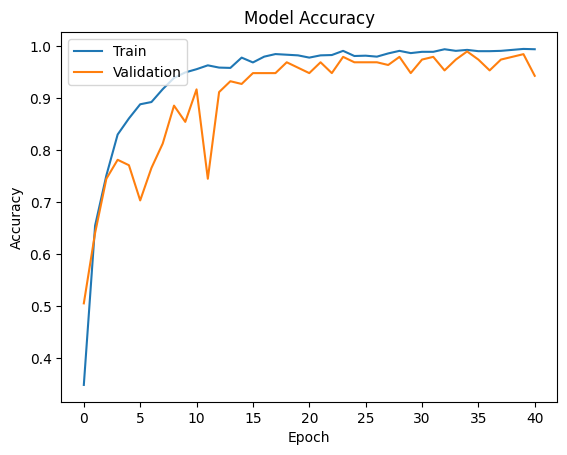

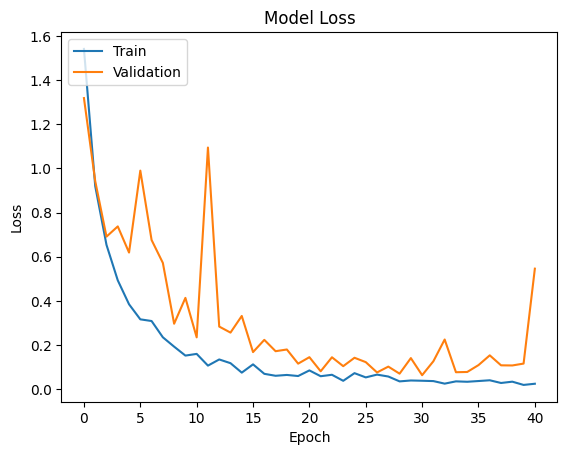

In [8]:
import os
from matplotlib import pyplot as plt
# Plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Saving the accuracy plot
if not os.path.exists('graphs'):
    os.makedirs('graphs')
plt.savefig('graphs/Custom and mobilenet accuracy.png')

# Plotting the loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Saving the loss plot
if not os.path.exists('graphs'):
    os.makedirs('graphs')
plt.savefig('graphs/Custom and mobilenet loss.png')

In [9]:
model1.evaluate(test_generator)

7/7 [==============================] - 1s 107ms/step - loss: 0.0776 - accuracy: 0.9717 - auc: 0.9969


[0.07756303250789642, 0.9716981053352356, 0.9968960881233215]

In [17]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelBinarizer

def predict_class(image_path, model, train_generator):
    # Load the image
    img = load_img(image_path, target_size=(224, 224))

    # Convert the image to a numpy array
    img_array = img_to_array(img)

    # Expand the dimensions of the numpy array
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class of the image
    class_prediction = model.predict(img_array)

    # Get the predicted class index
    class_index = np.argmax(class_prediction)

    # Get the class indices and names
    class_indices = train_generator.class_indices
    class_names = dict((v, k) for k, v in class_indices.items())

    # Get the predicted class name
    class_name = class_names[class_index]

    # Return the predicted class name
    return class_name


In [42]:
user_input = input()
path = user_input[1:-1]
class_index = predict_class(path, model1, train_generator)
print(class_index)


 "C:\Users\rushi\Downloads\test2.jpg"


1/1 [==============================] - 0s 18ms/step
Rust


In [43]:
train_generator.class_indices

{'Early Shoot Borer': 0,
 'Healthy': 1,
 'Mosaic': 2,
 'RedRot': 3,
 'Rust': 4,
 'Wolly Aphid': 5}